### Visualize MonoDTR
- https://github.com/kuanchihhuang/monodtr
1. 구글 드라이브 마운트
2. 런타임 도구 GPU로 변경

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Installation

In [2]:
import sys
PROJECT_PATH = '/content/drive/MyDrive/2022CocacolaDrive/'
sys.path.append(PROJECT_PATH+'MonoDTR/')
from visualDet3D.utils.utils import draw_3D_box
# from visualDet3D.networks.utils import BBox3dProjector, BackProjection

sys.path.append("../")
import importlib
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch

from sys import stdout

### Definition

In [3]:
def draw_bbox2d_to_image(image, bboxes2d, color=(255, 0, 255)):
    drawed_image = image.copy()
    for box2d in bboxes2d:
        cv2.rectangle(drawed_image, (int(box2d[0]), int(box2d[1])), (int(box2d[2]), int(box2d[3])), color, 3)
    return drawed_image

In [4]:
def compute_birdviewbox(bbox_3d_state_3ds, shape, scale):
    corners_2Ds = []
    for bbox_3d_state_3d in bbox_3d_state_3ds:
        # bbox_3d_state_3d = [x_center, y_center, z_center, w, h, l, alpha]
        h = bbox_3d_state_3d[4] * scale
        w = bbox_3d_state_3d[3] * scale
        l = bbox_3d_state_3d[5] * scale
        x = bbox_3d_state_3d[0] * scale
        y = bbox_3d_state_3d[1] * scale
        z = bbox_3d_state_3d[2] * scale
        rot_y = bbox_3d_state_3d[6]

        R = np.array([[-np.cos(rot_y), np.sin(rot_y)],
                    [np.sin(rot_y), np.cos(rot_y)]])
        t = np.array([x, z]).reshape(1, 2).T

        x_corners = [0, l, l, 0]  # -l/2
        z_corners = [w, w, 0, 0]  # -w/2


        x_corners += -w / 2
        z_corners += -l / 2

        # bounding box in object coordinate
        corners_2D = np.array([x_corners, z_corners])
        # rotate
        corners_2D = R.dot(corners_2D)
        # translation
        corners_2D = t - corners_2D
        # in camera coordinate
        corners_2D[0] += int(shape/2)
        corners_2D = (corners_2D).astype(np.int16)
        corners_2D = corners_2D.T

        corners_2Ds.append(corners_2D)

    return corners_2Ds

In [5]:
def getProjection(bbox_3d_ndarr, thetas_ndarr, tensor_p2):
  # register_buffer('corner_matrix', torch.tensor(
  #           [[-1, -1, -1],
  #           [ 1, -1, -1],
  #           [ 1,  1, -1],
  #           [ 1,  1,  1],
  #           [ 1, -1,  1],
  #           [-1, -1,  1],
  #           [-1,  1,  1],
  #           [-1,  1, -1]]
  #       ).float()  )# 8, 3
  corner_matrix = torch.tensor(
            [[-1, -1, -1],
            [ 1, -1, -1],
            [ 1,  1, -1],
            [ 1,  1,  1],
            [ 1, -1,  1],
            [-1, -1,  1],
            [-1,  1,  1],
            [-1,  1, -1]]
        ).float()

  bbox_3d=torch.Tensor(bbox_3d_ndarr)
  thetas=torch.Tensor(thetas_ndarr)

  relative_eight_corners = 0.5 * corner_matrix * bbox_3d[:, 3:6].unsqueeze(1)  # [N, 8, 3]

  _cos = torch.cos(thetas).unsqueeze(1)  # [N, 1]
  _sin = torch.sin(thetas).unsqueeze(1)  # [N, 1]
  rotated_corners_x, rotated_corners_z = (
      relative_eight_corners[:, :, 2] * _cos +
          relative_eight_corners[:, :, 0] * _sin,
  -relative_eight_corners[:, :, 2] * _sin +
      relative_eight_corners[:, :, 0] * _cos
  )  # relative_eight_corners == [N, 8, 3]
  rotated_corners = torch.stack([rotated_corners_x, relative_eight_corners[:,:,1], rotated_corners_z], dim=-1) #[N, 8, 3]
  abs_corners = rotated_corners + \
      bbox_3d[:, 0:3].unsqueeze(1)  # [N, 8, 3]
  camera_corners = torch.cat([abs_corners,
      abs_corners.new_ones([abs_corners.shape[0], corner_matrix.shape[0], 1])],
      dim=-1).unsqueeze(3)  # [N, 8, 4, 1]
  camera_coord = torch.matmul(tensor_p2, camera_corners).squeeze(-1)  # [N, 8, 3]

  homo_coord = camera_coord / (camera_coord[:, :, 2:] + 1e-6) # [N, 8, 3]

  return camera_coord, homo_coord

### Check(Pass)

In [ ]:
# res_paths = []
# img_path = PROJECT_PATH+'MonoDTR/data/KITTI/testing/image_2/'
# calib_path = PROJECT_PATH+'MonoDTR/data/KITTI/testing/calib/'
# res_paths.append(PROJECT_PATH+'MonoDTR/workdirs/MonoDTR/output/test/data/')
# # res_paths.append('/content/drive/Shareddrives/2022Cocacola/MonoDTR/workdirs/MonoDTR/output/test_own/data/')

# index = 50
# name = "%06d" % index

# img_path = img_path + name + '.png'
# calib_path = calib_path + name + '.txt'
# res_paths[0] = res_paths[0] + name + '.txt'
# # res_paths[1] = res_paths[1] + name + '.txt'

# print(img_path)
# print(calib_path)
# print(res_paths[0])
# # print(res_paths[1])

# # f = open(res_path)
# # len(f.readlines())

### Draw(Pass)

In [ ]:
# set calib
calib_path = '/content/drive/MyDrive/2022CocacolaDrive/MonoDTR/data/KITTI/testing/calib_bu/B.txt'

f = open(calib_path)
P2_str = f.readlines()[2]
f = open(calib_path)
P3_str = f.readlines()[3]
P2, P3 = [], []
for i in range(1,13):
  P2.append(float(P2_str.split(" ")[i]))
  P3.append(float(P3_str.split(" ")[i]))

tensor_p2 = torch.tensor(P2).reshape(3,4)
tensor_p3 = torch.tensor(P3).reshape(3,4)

print(tensor_p2)
print(tensor_p3)

tensor([[ 1.2406e+03,  0.0000e+00,  9.7469e+02, -7.3700e+00],
        [ 0.0000e+00,  8.0519e+02,  3.9096e+02,  3.3165e+02],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00]])
tensor([[ 1.2406e+03,  0.0000e+00,  9.7469e+02, -7.3700e+00],
        [ 0.0000e+00,  8.0519e+02,  3.9096e+02,  3.3165e+02],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  9.5000e-01]])


[[1.5101703e+03 1.6252689e+03 1.6252689e+03 1.4162574e+03 1.4162574e+03
  1.3040902e+03 1.3040902e+03 1.5101703e+03]
 [4.6059601e+02 4.6671375e+02 5.3597003e+02 5.5865466e+02 4.7856433e+02
  4.7048492e+02 5.4318890e+02 5.2425934e+02]
 [9.9999988e-01 9.9999994e-01 9.9999994e-01 9.9999994e-01 9.9999994e-01
  9.9999994e-01 9.9999994e-01 9.9999988e-01]]
[[1.4310680e+03 1.5330830e+03 1.5330830e+03 1.3241775e+03 1.3241775e+03
  1.2266582e+03 1.2266582e+03 1.4310680e+03]
 [4.3647015e+02 4.4024155e+02 5.0556958e+02 5.2233295e+02 4.4744980e+02
  4.4254929e+02 5.1093637e+02 4.9679880e+02]
 [9.9999988e-01 9.9999988e-01 9.9999988e-01 9.9999994e-01 9.9999994e-01
  9.9999994e-01 9.9999994e-01 9.9999988e-01]]


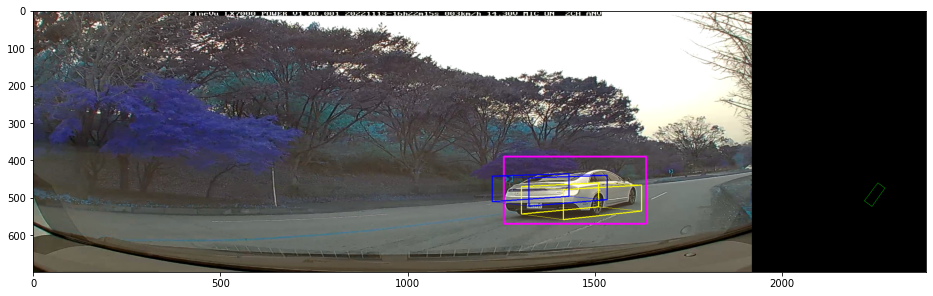

In [ ]:
res_paths = []
PROJECT_PATH = '/content/drive/MyDrive/2022CocacolaDrive/'
res_paths.append(PROJECT_PATH+'MonoDTR/workdirs/MonoDTR/output/test/data/000158.txt')
img_path = PROJECT_PATH+'MonoDTR/data/KITTI/testing/image_2/000158.png'

for res_path in res_paths:
    # 검출 결과 불러오기
    f = open(res_path)
    lines = f.readlines()

    # 이미지 파일 불러오기
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    # image = cv2.resize(image,(1242,375))
    rgb_image = image.transpose(0, 1, 2)

    # rgb_image = cv2.flip(rgb_image, 1)
    # rgb_image = cv2.flip(rgb_image, 0)

    height = rgb_image.shape[0]
    width = rgb_image.shape[1]

    # plotting 초기화
    plt.close()
    fig = plt.figure(figsize=(16,9))

    # 차량이 검출 되었다면
    if len(lines) > 0:
        detected_cnt = 0
        bbox_2d = np.zeros((len(lines), 4))
        bbox_3d_state_3d = np.zeros((len(lines), 7))
        thetas = np.zeros(len(lines))
        scores = np.zeros(len(lines))
        
        for line in lines:
            infos = line.split()

            # output의 형태 /visualDet3D/data/kitti/utils.py 참조
            # text_to_write += ('{} -1 -1 {:.6f} {:.6f} {:.6f} {:.6f} {:.6f} {:.6f} {:.6f} {:.6f} {:.6f} {:.6f} {:.6f} {:.6f} {} \n').format(
            #           obj_types[i], bbox_3d_state_3d[i][-1], bbox[0], bbox[1], bbox[2], bbox[3],
            #           bbox_3d_state_3d[i][4], bbox_3d_state_3d[i][3], bbox_3d_state_3d[i][5],
            #           bbox_3d_state_3d[i][0], bbox_3d_state_3d[i][1], bbox_3d_state_3d[i][2],
            #           thetas[i], scores[i])

            # bbox_3d_state_3d = [x_center, y_center, z_center, w, h, l, alpha]
            # Backprojector를 완료한 데이터.
            # projector를 실행한 결과는 없으나 theta가 projector의 output중 하나.
            # /visualDet3D/networks/pipelines/evaluators.py 의 test_one() 참조

            # bbox_2d
            bbox_2d[detected_cnt][0] = infos[4]
            bbox_2d[detected_cnt][1] = infos[5]
            bbox_2d[detected_cnt][2] = infos[6]
            bbox_2d[detected_cnt][3] = infos[7]


            # bbox_3d_state_3d = [x_center, y_center, z_center, w, h, l, alpha]
            bbox_3d_state_3d[detected_cnt][0] = infos[11]
            bbox_3d_state_3d[detected_cnt][1] = infos[12] #float(infos[12])-0.6
            bbox_3d_state_3d[detected_cnt][2] = infos[13]

            bbox_3d_state_3d[detected_cnt][4] = infos[8]
            bbox_3d_state_3d[detected_cnt][3] = infos[9]
            bbox_3d_state_3d[detected_cnt][5] = infos[10]
            
            bbox_3d_state_3d[detected_cnt][6] = infos[3]

            thetas[detected_cnt] = infos[14]
            scores[detected_cnt] = infos[15]

            detected_cnt += 1

        camera_coord, homo_coord = getProjection(bbox_3d_state_3d, thetas, tensor_p2)
        camera_coord3, homo_coord3 = getProjection(bbox_3d_state_3d, thetas, tensor_p3)

        # 2D 그리기
        rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d, (255, 0, 255))

        # 3D 그리기
        for box in homo_coord:
            box = box.cpu().numpy().T
            print(box)
            rgb_image = draw_3D_box(rgb_image, box, color = (255, 255, 0))

        for box in homo_coord3:
            box = box.cpu().numpy().T
            print(box)
            rgb_image = draw_3D_box(rgb_image, box, color = (0, 0, 255))

shape = int(height//1.5)
bevs = compute_birdviewbox(bbox_3d_state_3d, shape, 15)

black_canvas = np.zeros((height, shape, 3), dtype="uint8")
green = (0, 255, 0)

for bev in bevs:    
    cv2.line(black_canvas, bev[0], bev[1], green)
    cv2.line(black_canvas, bev[2], bev[1], green)
    cv2.line(black_canvas, bev[2], bev[3], green)
    cv2.line(black_canvas, bev[0], bev[3], green)

black_canvas = cv2.flip(black_canvas, 0)
vis = np.concatenate((rgb_image, black_canvas), axis=1)
plt.imshow(vis)
plt.show()

### Draw Test Set

In [6]:
# ! rm -rf /content/drive/MyDrive/2022CocacolaDrive/MonoDTR/workdirs/MonoDTR/output/case5/*

In [7]:
index = 0
set_size = 171
caseDiv = 'case5'


case_path = PROJECT_PATH+'MonoDTR/workdirs/MonoDTR/output/'+caseDiv+'/'
set_size *= 2

prg_N = set_size
n = 1

if not os.path.exists(os.path.dirname(case_path)):
    os.makedirs(os.path.dirname(case_path))

for nm_i in range(index, index+set_size):
    res_path = PROJECT_PATH+'MonoDTR/workdirs/MonoDTR/output/test/data/'
    img_path = PROJECT_PATH+'MonoDTR/data/KITTI/testing/image_2/'
    calib_path = PROJECT_PATH+'MonoDTR/data/KITTI/testing/calib/'
    vis_path = PROJECT_PATH+'MonoDTR/workdirs/MonoDTR/output/test_bev/'
    case_path = PROJECT_PATH+'MonoDTR/workdirs/MonoDTR/output/'+caseDiv+'/'

    name = "%06d" % nm_i
    res_path = res_path + name + '.txt'
    img_path = img_path + name + '.png'
    calib_path = calib_path + name + '.txt'
    vis_path = vis_path + name + '.png'
    case_path = case_path + name + '.png'
    
    ### LOG
    printout = f'\r{case_path} : {n}/{prg_N}'
    stdout.write(printout)
    n += 1
    ###

    # set calib
    f = open(calib_path)
    P2_str = f.readlines()[2]
    f = open(calib_path)
    P3_str = f.readlines()[3]
    P2, P3 = [], []
    for i in range(1,13):
        P2.append(float(P2_str.split(" ")[i]))
        P3.append(float(P3_str.split(" ")[i]))

    tensor_p2 = torch.tensor(P2).reshape(3,4)
    tensor_p3 = torch.tensor(P3).reshape(3,4)

    # 검출 결과 불러오기
    f = open(res_path)
    lines = f.readlines()

    # 이미지 파일 불러오기
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    rgb_image = image.transpose(0, 1, 2)

    height = rgb_image.shape[0]
    shape = int(height//1.5)
    width = rgb_image.shape[1]

    # plotting 초기화
    plt.close()
    fig = plt.figure(figsize=(16,9))

    bevs = []
    # 차량이 검출 되었다면
    if len(lines) > 0:
        detected_cnt = 0
        bbox_2d = np.zeros((len(lines), 4))
        bbox_3d_state_3d = np.zeros((len(lines), 7))
        thetas = np.zeros(len(lines))
        scores = np.zeros(len(lines))
        
        for line in lines:
            infos = line.split()

            bbox_2d[detected_cnt][0] = infos[4]
            bbox_2d[detected_cnt][1] = infos[5]
            bbox_2d[detected_cnt][2] = infos[6]
            bbox_2d[detected_cnt][3] = infos[7]

            bbox_3d_state_3d[detected_cnt][0] = infos[11]
            bbox_3d_state_3d[detected_cnt][1] = infos[12] #float(infos[12])-0.6
            bbox_3d_state_3d[detected_cnt][2] = infos[13]

            bbox_3d_state_3d[detected_cnt][4] = infos[8]
            bbox_3d_state_3d[detected_cnt][3] = infos[9]
            bbox_3d_state_3d[detected_cnt][5] = infos[10]
            
            bbox_3d_state_3d[detected_cnt][6] = infos[3]

            thetas[detected_cnt] = infos[14]
            scores[detected_cnt] = infos[15]

            detected_cnt += 1

        camera_coord, homo_coord = getProjection(bbox_3d_state_3d, thetas, tensor_p2)

        # 2D 그리기
        rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d, (255, 0, 255))

        # 3D 그리기
        for box in homo_coord:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)

        # bev 그리기
        shape = int(height//1.5)
        bevs = compute_birdviewbox(bbox_3d_state_3d, shape, 15)

    black_canvas = np.zeros((height, shape, 3), dtype="uint8")
    green = (0, 255, 0)

    for bev in bevs:    
        cv2.line(black_canvas, bev[0], bev[1], green, 3)
        cv2.line(black_canvas, bev[2], bev[1], green, 3)
        cv2.line(black_canvas, bev[2], bev[3], green, 3)
        cv2.line(black_canvas, bev[0], bev[3], green, 3)
    black_canvas = cv2.flip(black_canvas, 0)
    
    vis = np.concatenate((rgb_image, black_canvas), axis=1)

    cv2.imwrite(case_path, vis, [cv2.IMWRITE_JPEG_QUALITY, 100])


/content/drive/MyDrive/2022CocacolaDrive/MonoDTR/workdirs/MonoDTR/output/case5/000341.png : 342/342

<Figure size 1152x648 with 0 Axes>

### concat png

In [8]:
# index = 0
# set_size = 129
# set_size *= 2
# caseDiv = 'case3'

for nm_i in range( index, index+(set_size//2) ):
    # res_path = PROJECT_PATH+'MonoDTR/workdirs/MonoDTR/output/test/data/'
    # img_path = PROJECT_PATH+'MonoDTR/data/KITTI/testing/image_2/'
    # calib_path = PROJECT_PATH+'MonoDTR/data/KITTI/testing/calib/'
    vis_path = PROJECT_PATH+'MonoDTR/workdirs/MonoDTR/output/test_bev/'
    case_path = PROJECT_PATH+'MonoDTR/workdirs/MonoDTR/output/'+caseDiv+'/'

    name = "%06d" % nm_i
    # res_path = res_path + name + '.txt'
    # img_path = img_path + name + '.png'
    # calib_path = calib_path + name + '.txt'
    # vis_path = vis_path + name + '.png'

    # vis_path = PROJECT_PATH+'MonoDTR/workdirs/MonoDTR/output/test_bev/'
    a_name = "%06d" % (nm_i)
    b_name = "%06d" % (nm_i+set_size//2)
    concat_name = 'concat' + "%06d" % (nm_i)

    a_image = cv2.imread(case_path + a_name + '.png', cv2.IMREAD_COLOR)
    a_image = a_image.transpose(0, 1, 2)
    b_image = cv2.imread(case_path + b_name + '.png', cv2.IMREAD_COLOR)
    b_image = b_image.transpose(0, 1, 2)

    concat_vis = np.concatenate((a_image, b_image), axis=0)
    cv2.imwrite(case_path + concat_name + '.png', concat_vis)

### Draw A, B individually

In [9]:
import imageio
from PIL import Image

# vis_path = PROJECT_PATH+'MonoDTR/workdirs/MonoDTR/output/test_bev/'
case_path = PROJECT_PATH+'MonoDTR/workdirs/MonoDTR/output/'+caseDiv+'/'

if not os.path.exists(os.path.dirname(case_path)):
    os.makedirs(os.path.dirname(case_path))
 
fps_set = 30
frame_gap = 30//fps_set

pathList = [case_path+f"{i}" for i in os.listdir(case_path)]
pathListCopy = pathList.copy()

for _p in pathListCopy:
    if ('gif' in _p):
        pathList.remove(_p)
    elif ('concat' in _p):
        pathList.remove(_p)
    elif ('ipynb' in _p):
        pathList.remove(_p)

pathAB = [ pathList[:len(pathList)//2], pathList[len(pathList)//2:] ]
for path_i, path in enumerate(pathAB):
    paths = [  Image.open(i) for idx, i in enumerate(path) if idx%frame_gap==0 ]
    imageio.mimsave(case_path+'Res_'+caseDiv+'_'+chr(path_i+65)+str(fps_set)+'fps_test.gif', paths, fps=fps_set)

### Draw A,B Concatenate

In [10]:
import imageio
from PIL import Image

case_path = PROJECT_PATH+'MonoDTR/workdirs/MonoDTR/output/'+caseDiv+'/'
if not os.path.exists(os.path.dirname(case_path)):
    os.makedirs(os.path.dirname(case_path))
    
fps_set = 30
frame_gap = 30//fps_set

pathList = [case_path+f"{i}" for i in os.listdir(case_path)]
pathListCopy = pathList.copy()

for _p in pathListCopy:
    if ('gif' in _p):
        pathList.remove(_p)
    elif ('concat' not in _p):
        pathList.remove(_p)
    elif ('ipynb' in _p):
        pathList.remove(_p)


paths = [  Image.open(i) for idx, i in enumerate(pathList) if idx%frame_gap==0 ]
imageio.mimsave(case_path+'Res_concat_'+caseDiv+'_'+str(fps_set)+'fps_test.gif', paths, fps=fps_set)

In [11]:
print(pathList)

['/content/drive/MyDrive/2022CocacolaDrive/MonoDTR/workdirs/MonoDTR/output/case5/concat000000.png', '/content/drive/MyDrive/2022CocacolaDrive/MonoDTR/workdirs/MonoDTR/output/case5/concat000001.png', '/content/drive/MyDrive/2022CocacolaDrive/MonoDTR/workdirs/MonoDTR/output/case5/concat000002.png', '/content/drive/MyDrive/2022CocacolaDrive/MonoDTR/workdirs/MonoDTR/output/case5/concat000003.png', '/content/drive/MyDrive/2022CocacolaDrive/MonoDTR/workdirs/MonoDTR/output/case5/concat000004.png', '/content/drive/MyDrive/2022CocacolaDrive/MonoDTR/workdirs/MonoDTR/output/case5/concat000005.png', '/content/drive/MyDrive/2022CocacolaDrive/MonoDTR/workdirs/MonoDTR/output/case5/concat000006.png', '/content/drive/MyDrive/2022CocacolaDrive/MonoDTR/workdirs/MonoDTR/output/case5/concat000007.png', '/content/drive/MyDrive/2022CocacolaDrive/MonoDTR/workdirs/MonoDTR/output/case5/concat000008.png', '/content/drive/MyDrive/2022CocacolaDrive/MonoDTR/workdirs/MonoDTR/output/case5/concat000009.png', '/content